In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
import random
import math
import xpress  as xp

Using the Community license in this session. If you have a full Xpress license, first set the XPAUTH_PATH environment variable to the full path to your license file, xpauth.xpr, and then restart Python. If you want to use the FICO Community license and no longer want to see this message, set the XPAUTH_PATH environment variable to: /home/andrea/anaconda3/lib/python3.9/site-packages/xpress/license/community-xpauth.xpr
NB: setting XPAUTH_PATH will also affect any other Xpress products installed on your system.


In [2]:
# input
L = 2

custom_setup = True
if custom_setup:
    C = 8
else:
    C = 10 # change this input for other runs

map_size = 100
ratio_locker_customers = 0.3
ratio_prime_door_to_door_customer = 0.4

In [3]:
# define the locations of customers and lockers and warehouse
if custom_setup:
    C_location = np.array([[0.1 ,0.28], [0.2 ,0.4],[0.15 ,0.7], [0.3 ,0.7],[0.8 ,0.6],[0.7 ,0.4],[0.9 ,0.5], [0.4, 0.15]])
    W_location = np.array([[0.6 ,0.5]])
    L_location = np.array([[0.3 ,0.5],[0.5,0.2]])
else:
    C_location = np.random.randint(map_size, size=(C, 2))
    W_location = np.random.randint(map_size, size=(1, 2))
    L_location = np.random.randint(map_size, size=(L, 2))
stores_location = np.concatenate((W_location, L_location), axis=0)

In [4]:
def euclidean_distance(location_a, location_b):
    if len(location_a) != 2 or len(location_b) != 2:
        raise Exception("the two location need to be a list each of size 2")
    delta_x = location_b[0]-location_a[0]
    delta_y = location_b[1]-location_a[1]
    return math.sqrt(delta_x*delta_x+delta_y*delta_y)

def find_nearest_stores_from_customer(customer_location, stores_location_par):
    min_distance = float("inf")
    nearest_store_location = []
    index = 0
    nearest_locker_index = -1
    for store_location in stores_location_par:
        distance = euclidean_distance(customer_location, store_location)
        if distance < min_distance:
            min_distance = distance
            nearest_store_location = store_location
            nearest_locker_index = index
        index +=1
    return nearest_locker_index, nearest_store_location


In [5]:
# Customers’ demand and preferences

# define all the stores: eg. stores = [W, L0, L1, .... , Lx]
warehouse = ["W"]
lockers = []
for l in range(L):
    lockers.append("L"+str(l))
stores = warehouse+lockers

if custom_setup:
    C_L = [0, 5, 7]
    C_D = [1, 2, 3, 4, 6]
    S_k =[1, 2, 6]
    a_k = ["L0", "W", "L1"]
else:
    C_L = []
    C_D = []
    S_k = []
    a_k = []
    for client in range(C):
        if random.random()  <= ratio_locker_customers :
            # locker customer
            C_L.append(client)
            a_k.append(random.choice(stores))
        else:
            # door to door customer
            C_D.append(client)
            if random.random() >= ratio_prime_door_to_door_customer:
                S_k.append(client)

In [6]:
# Capacities

q_c = np.ones(C)
q_CD = np.ones(len(C_D)) # TODO take the value of q_c only in the index of a CD customer
q_CL = np.ones(len(C_L)) # TODO take the value of q_c only in the index of a CL customer
q_SK = np.ones(len(S_k)) # TODO take the value of q_c only in the index of a S_k customer

# PF vehicles capacities
Q = math.ceil(0.5 * len(C_D))
# locker storage (every locker has the same capacity by default)
W_l = []
for i in range(L):
    W_l.append(math.ceil(0.8 * C / L))
# LF vehicles capacities (every LF vehicle has the same capacity by default)
Q_l = []
for i in range(L):
    Q_l.append(math.ceil(0.6 * W_l[i]))

sum_W_l = 0
for i in range(len(W_l)):
    sum_W_l += W_l[i]


# supply vehicles storage
Q_L = math.ceil(0.8 * sum_W_l)

print("Q: ",Q)
print("W_l: ",W_l)
print("Q_l: ",Q_l)
print("Q_L: ",Q_L)
print("sum_W_l: ", sum_W_l)


Q:  3
W_l:  [4, 4]
Q_l:  [3, 3]
Q_L:  7
sum_W_l:  8


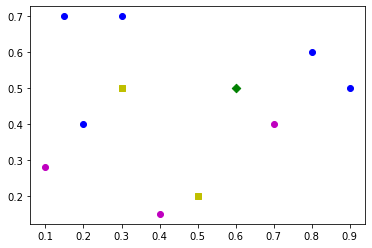

In [7]:
CD_location = np.array([[0,0]])
CL_location = np.array([[0,0]])
S_k_location = np.array([[0,0]])
for i in range(C):
    if i in  C_D:
        CD_location=np.vstack([CD_location, C_location[i]])
    else:
        CL_location = np.vstack([CL_location, C_location[i]])
for i in range(C):
    if i in S_k:
        S_k_location=np.vstack([S_k_location,C_location[i]])

S_k_location=np.delete(S_k_location,0,0)
CD_location = np.delete(CD_location, 0, 0)
CL_location = np.delete(CL_location, 0, 0)

#define indexes for the subset S_k
S_k_indexes = []
for s in range(len(S_k_location)):
    S_k_indexes.append("Sk"+str(s))


#define all customers
Customers = []
Customers_door = []
Customers_locker = []
for c in range(len(C_D)):
    Customers_door.append("Cd"+str(c))
for c in range(len(C_L)):
    Customers_locker.append("Cl"+str(c))

Customers = Customers_door+Customers_locker


plt.scatter(CD_location[:,0],CD_location[:,1],color='b')
plt.scatter(CL_location[:,0],CL_location[:,1],color='m')
plt.scatter(W_location[:,0],W_location[:,1],color='g',marker='D')
plt.scatter(L_location[:,0],L_location[:,1],color ='y',marker='s')

#piccola nota
#come nel paper in verde è la warehouse, in giallo i locker, mentre in blu in customer door to door e in magenta i customer locker

In [8]:
#calcolo la matrice delle distanze:
all_locations = np.array([])
all_locations = np.append(all_locations,W_location)
all_locations = np.vstack([all_locations,L_location])
all_locations = np.vstack([all_locations,CD_location])
all_locations = np.vstack([all_locations,CL_location])

all_buildings = stores + Customers

df = pd.DataFrame(all_locations, columns=['xcord', 'ycord'], index=all_buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy =dist_matrix.to_numpy()
print(dist_matrix)

            W        L0        L1       Cd0       Cd1       Cd2       Cd3  \
W    0.000000  0.300000  0.316228  0.412311  0.492443  0.360555  0.223607   
L0   0.300000  0.000000  0.360555  0.141421  0.250000  0.200000  0.509902   
L1   0.316228  0.360555  0.000000  0.360555  0.610328  0.538516  0.500000   
Cd0  0.412311  0.141421  0.360555  0.000000  0.304138  0.316228  0.632456   
Cd1  0.492443  0.250000  0.610328  0.304138  0.000000  0.150000  0.657647   
Cd2  0.360555  0.200000  0.538516  0.316228  0.150000  0.000000  0.509902   
Cd3  0.223607  0.509902  0.500000  0.632456  0.657647  0.509902  0.000000   
Cd4  0.300000  0.600000  0.500000  0.707107  0.776209  0.632456  0.141421   
Cl0  0.546260  0.297321  0.407922  0.156205  0.422966  0.465188  0.769675   
Cl1  0.141421  0.412311  0.282843  0.500000  0.626498  0.500000  0.223607   
Cl2  0.403113  0.364005  0.111803  0.320156  0.604152  0.559017  0.602080   

          Cd4       Cl0       Cl1       Cl2  
W    0.300000  0.546260  0.14

In [9]:
#filter data
supply_distances_matrix = dist_matrix.filter(items=stores, axis=1)
supply_distances_matrix = supply_distances_matrix.filter(items=stores, axis=0)
print(supply_distances_matrix)

PF_distances_matrix = dist_matrix.filter(items=['W'] + Customers_door, axis=1)
PF_distances_matrix = PF_distances_matrix.filter(items=['W'] + Customers_door, axis=0)
print(PF_distances_matrix)

LF_distances_matrix = dist_matrix.filter(items=Customers_door, axis=1)
LF_distances_matrix = LF_distances_matrix.filter(items=lockers + Customers_door, axis=0)
print(LF_distances_matrix)

           W        L0        L1
W   0.000000  0.300000  0.316228
L0  0.300000  0.000000  0.360555
L1  0.316228  0.360555  0.000000
            W       Cd0       Cd1       Cd2       Cd3       Cd4
W    0.000000  0.412311  0.492443  0.360555  0.223607  0.300000
Cd0  0.412311  0.000000  0.304138  0.316228  0.632456  0.707107
Cd1  0.492443  0.304138  0.000000  0.150000  0.657647  0.776209
Cd2  0.360555  0.316228  0.150000  0.000000  0.509902  0.632456
Cd3  0.223607  0.632456  0.657647  0.509902  0.000000  0.141421
Cd4  0.300000  0.707107  0.776209  0.632456  0.141421  0.000000
          Cd0       Cd1       Cd2       Cd3       Cd4
L0   0.141421  0.250000  0.200000  0.509902  0.600000
L1   0.360555  0.610328  0.538516  0.500000  0.500000
Cd0  0.000000  0.304138  0.316228  0.632456  0.707107
Cd1  0.304138  0.000000  0.150000  0.657647  0.776209
Cd2  0.316228  0.150000  0.000000  0.509902  0.632456
Cd3  0.632456  0.657647  0.509902  0.000000  0.141421
Cd4  0.707107  0.776209  0.632456  0.14142

In [10]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75

PF_delivery_cost = pi*PF_distances_matrix
LF_delivery_cost = pi_l*LF_distances_matrix
supply_cost = pi_L*supply_distances_matrix
print(supply_cost)
print(PF_delivery_cost)
print(LF_delivery_cost)

           W        L0        L1
W   0.000000  0.225000  0.237171
L0  0.225000  0.000000  0.270416
L1  0.237171  0.270416  0.000000
            W       Cd0       Cd1       Cd2       Cd3       Cd4
W    0.000000  0.412311  0.492443  0.360555  0.223607  0.300000
Cd0  0.412311  0.000000  0.304138  0.316228  0.632456  0.707107
Cd1  0.492443  0.304138  0.000000  0.150000  0.657647  0.776209
Cd2  0.360555  0.316228  0.150000  0.000000  0.509902  0.632456
Cd3  0.223607  0.632456  0.657647  0.509902  0.000000  0.141421
Cd4  0.300000  0.707107  0.776209  0.632456  0.141421  0.000000
          Cd0       Cd1       Cd2       Cd3       Cd4
L0   0.120208  0.212500  0.170000  0.433417  0.510000
L1   0.306472  0.518779  0.457739  0.425000  0.425000
Cd0  0.000000  0.258517  0.268794  0.537587  0.601041
Cd1  0.258517  0.000000  0.127500  0.559000  0.659777
Cd2  0.268794  0.127500  0.000000  0.433417  0.537587
Cd3  0.537587  0.559000  0.433417  0.000000  0.120208
Cd4  0.601041  0.659777  0.537587  0.12020

In [11]:
#compensation
compensation_locations = np.array([])
compensation_locations = np.append(compensation_locations,W_location)
compensation_locations = np.vstack([compensation_locations,L_location])
compensation_locations = np.vstack([compensation_locations,S_k_location])

df_compensation = pd.DataFrame(compensation_locations, columns=['xcord', 'ycord'], index=stores+S_k_indexes)
compensation_matrix= pd.DataFrame(distance_matrix(df_compensation.values, df_compensation.values), index=df_compensation.index, columns=df_compensation.index)

print(compensation_matrix)


distance_matrix_customer_locker_store = dist_matrix.filter(items=Customers_locker,axis=1)
distance_matrix_customer_locker_store = distance_matrix_customer_locker_store.filter(items=stores,axis=0)
print(distance_matrix_customer_locker_store)


closest_store_to_CL = distance_matrix_customer_locker_store.idxmin()
print(closest_store_to_CL)

index_close_locker = []
for i in range(len(closest_store_to_CL)):
    index_close_locker.append(closest_store_to_CL[i])
print(index_close_locker)


# TODO matrix layout to reformat
d_ak_c = compensation_matrix.filter(items = S_k_indexes,axis=1)
d_ak_c=d_ak_c.filter(items=index_close_locker,axis=0)
print(d_ak_c)

ro = 0.5
compensation_matrix_cost = ro*d_ak_c
print(compensation_matrix_cost)
print(compensation_matrix_cost.values[1][0])


            W        L0        L1       Sk0       Sk1       Sk2
W    0.000000  0.300000  0.316228  0.412311  0.492443  0.300000
L0   0.300000  0.000000  0.360555  0.141421  0.250000  0.600000
L1   0.316228  0.360555  0.000000  0.360555  0.610328  0.500000
Sk0  0.412311  0.141421  0.360555  0.000000  0.304138  0.707107
Sk1  0.492443  0.250000  0.610328  0.304138  0.000000  0.776209
Sk2  0.300000  0.600000  0.500000  0.707107  0.776209  0.000000
         Cl0       Cl1       Cl2
W   0.546260  0.141421  0.403113
L0  0.297321  0.412311  0.364005
L1  0.407922  0.282843  0.111803
Cl0    L0
Cl1     W
Cl2    L1
dtype: object
['L0', 'W', 'L1']
         Sk0       Sk1  Sk2
L0  0.141421  0.250000  0.6
W   0.412311  0.492443  0.3
L1  0.360555  0.610328  0.5
         Sk0       Sk1   Sk2
L0  0.070711  0.125000  0.30
W   0.206155  0.246221  0.15
L1  0.180278  0.305164  0.25
0.206155281280883


In [94]:
# Xpress formulation
single_period_problem = xp.problem()

In [95]:
# var definition
I_PF = 1 + len(C_D)
J_PF = 1 + len(C_D)
x_i_j = np.array([[xp.var(name="x_"+str(i)+"_"+str(j), vartype=xp.binary) for i in range(I_PF)]for j in range(J_PF)], dtype=xp.npvar)
y_i_j = np.array([[xp.var(name="y_"+str(i)+"_"+str(j), vartype=xp.integer) for i in range(I_PF)]for j in range(J_PF)], dtype=xp.npvar)

I_L = 1 + L
J_L = 1 + L
x_i_j_L = np.array([[xp.var(name="x_L_"+str(i)+"_"+str(j), vartype=xp.binary) for i in range(I_L)]for j in range(J_L)], dtype=xp.npvar)
y_i_j_L = np.array([[xp.var(name="y_L_"+str(i)+"_"+str(j), vartype=xp.integer) for i in range(I_L)]for j in range(J_L)], dtype=xp.npvar)

I_LF = 1 + len(C_D)
J_LF = 1 + len(C_D)
x_l_i_j = np.array([[[xp.var(name="x_l"+str(l)+"_"+str(i)+"_"+str(j), vartype=xp.binary) for i in range(I_LF)]for j in range(J_LF)] for l in range(L)], dtype=xp.npvar)
y_l_i_j = np.array([[[xp.var(name="y_l"+str(l)+"_"+str(i)+"_"+str(j), vartype=xp.integer) for i in range(I_LF)]for j in range(J_LF)] for l in range(L)], dtype=xp.npvar)

z_c = np.array([xp.var(name="z_c"+str(c), vartype=xp.binary) for c in range(len(C_D))], dtype=xp.npvar)
z_c_l = np.array([[xp.var(name="z_c"+str(c)+"_l"+str(l), vartype=xp.binary) for c in range(len(C_D))]for l in range(L)], dtype=xp.npvar)
z_l_L = np.array([[xp.var(name="z_l_L_"+str(l), vartype=xp.binary) for l in range(L)]], dtype=xp.npvar)

w_c_k = np.array([[xp.var(name="w_c"+str(c)+"_k"+str(k), vartype=xp.binary) for c in range(len(S_k))]for k in range(len(C_L))], dtype=xp.npvar)

# add var to the problem
single_period_problem.addVariable(x_i_j)
single_period_problem.addVariable(x_i_j_L)
single_period_problem.addVariable(x_l_i_j)

single_period_problem.addVariable(y_i_j)
single_period_problem.addVariable(y_i_j_L)
single_period_problem.addVariable(y_l_i_j)

single_period_problem.addVariable(z_c)
single_period_problem.addVariable(z_c_l)
single_period_problem.addVariable(z_l_L)

single_period_problem.addVariable(w_c_k)

In [96]:
# test code cell , TODO delete this cell
print(w_c_k)

[[w_c0_k0 w_c1_k0 w_c2_k0]
 [w_c0_k1 w_c1_k1 w_c2_k1]
 [w_c0_k2 w_c1_k2 w_c2_k2]]


In [97]:
# define constraints Customers’ service

# constraint eq. 2
for c in range(len(C_D)):
    single_period_problem.addConstraint( z_c[c] + xp.Sum(w_c_k[s][k] for s in range(len(S_k)) for k in range(len(C_L))) + xp.Sum(z_c_l[l][c] for l in range(L)) == 1)

# constraint eq. 3
for c_l in range(len(C_L)):
    single_period_problem.addConstraint( xp.Sum(w_c_k[c_l][s_k] for s_k in range(len(S_k))) <= 1)


# constraint eq. 4
for l in range(L):
    single_period_problem.addConstraint(
        xp.Sum(q_CL[cl] + xp.Sum(q_SK[sk]*w_c_k[cl][sk] for sk in range(len(S_k))) for cl in range(len(C_L)))
        + xp.Sum(q_CD[cd]*z_c_l[l][cd] for cd in range(len(C_D)))
        <= W_l[l] * z_l_L[0][l]
    )

# Professional fleet constraint

# constraint eq. 5.1 A == C
for i in range(len(C_D)):
    single_period_problem.addConstraint(
        xp.Sum( x_i_j[i+1][j] for j in range(len(C_D)+1))
        == z_c[i]
    )


# constraint eq. 5.2 B == C
for i in range(len(C_D)):
    single_period_problem.addConstraint(
        xp.Sum( x_i_j[j][i+1] for j in range(len(C_D)+1))
        == z_c[i]
    )

# constraint eq. 5.3 A == B
for i in range(len(C_D)):
    single_period_problem.addConstraint(
        xp.Sum( x_i_j[i+1][j] for j in range(len(C_D)+1))
        ==
        xp.Sum( x_i_j[j][i+1] for j in range(len(C_D)+1))
    )


# constraint eq. 6
single_period_problem.addConstraint(
    xp.Sum( x_i_j[0][j+1] for j in range(len(C_D)))
    - xp.Sum( x_i_j[j+1][0] for j in range(len(C_D)))
    == 0
)

# constraint eq. 7
for i in range(len(C_D)):
    single_period_problem.addConstraint(
        xp.Sum( y_i_j[j][i+1] for j in range(1+len(C_D)))
        - xp.Sum( y_i_j[i+1][j] for j in range(1+len(C_D)))
        == q_CD[i]*z_c[i]
    )

# constraint eq. 8
single_period_problem.addConstraint(
    xp.Sum( y_i_j[j+1][0] for j in range(len(C_D)))
    - xp.Sum( y_i_j[0][j+1] for j in range(len(C_D)))
    == - xp.Sum( q_CD[i]*z_c[i] for i in range(len(C_D)))
)

# constraint eq. 9
for i in range(1 + len(C_D)):
    for j in range(1 + len(C_D)):
        single_period_problem.addConstraint(
            y_i_j[i][j]
            <= Q * x_i_j[i][j]
        )

# constraint eq. 10
for i in range(len(C_D)):
    single_period_problem.addConstraint(
        y_i_j[i+1][0]
        == 0
    )

print(len(C_D))
print(len(C_L))
print(L)
print(len(C_D))
print(len(single_period_problem.getConstraint()))


5
3
2
5
73


# other matrix that may be useful

In [57]:
LF_distances_matrix_collection= {}
for i in range(L):
    l = [0]
    l[0]=lockers[i]
    local_matrix = dist_matrix.filter(items=l+Customers_door,axis=1)
    local_matrix = local_matrix.filter(items=l+Customers_door,axis=0)
    LF_distances_matrix_collection[i]=pd.DataFrame(local_matrix)

for key in LF_distances_matrix_collection.keys():
    print("\n" +"="*65)
    print(key)
    print("-"*65)
    print(LF_distances_matrix_collection[key])




0
-----------------------------------------------------------------
           L0       Cd0       Cd1       Cd2       Cd3       Cd4
L0   0.000000  0.141421  0.250000  0.200000  0.509902  0.600000
Cd0  0.141421  0.000000  0.304138  0.316228  0.632456  0.707107
Cd1  0.250000  0.304138  0.000000  0.150000  0.657647  0.776209
Cd2  0.200000  0.316228  0.150000  0.000000  0.509902  0.632456
Cd3  0.509902  0.632456  0.657647  0.509902  0.000000  0.141421
Cd4  0.600000  0.707107  0.776209  0.632456  0.141421  0.000000

1
-----------------------------------------------------------------
           L1       Cd0       Cd1       Cd2       Cd3       Cd4
L1   0.000000  0.360555  0.610328  0.538516  0.500000  0.500000
Cd0  0.360555  0.000000  0.304138  0.316228  0.632456  0.707107
Cd1  0.610328  0.304138  0.000000  0.150000  0.657647  0.776209
Cd2  0.538516  0.316228  0.150000  0.000000  0.509902  0.632456
Cd3  0.500000  0.632456  0.657647  0.509902  0.000000  0.141421
Cd4  0.500000  0.707107  0.776

In [13]:
#compensation
compensation_locations = np.array([])
compensation_locations = np.append(compensation_locations,W_location)
compensation_locations = np.vstack([compensation_locations,L_location])
compensation_locations = np.vstack([compensation_locations,S_k_location])

df_compensation = pd.DataFrame(compensation_locations, columns=['xcord', 'ycord'], index=stores+S_k_indexes)
compensation_matrix= pd.DataFrame(distance_matrix(df_compensation.values, df_compensation.values), index=df_compensation.index, columns=df_compensation.index)

print(compensation_matrix)


comp = dist_matrix.filter(items=Customers_locker,axis=1)
comp = comp.filter(items=stores,axis=0)
print(comp)

index_close_locker = ['']

d_ak_c = {}
for i in range(len(comp)):
    closest_locker =comp[Customers_locker[i]].idxmin()
    index_close_locker[0] = closest_locker
    local_comp_matrix = compensation_matrix.filter(items = S_k_indexes,axis=1)
    local_comp_matrix=local_comp_matrix.filter(items=index_close_locker,axis=0)
    d_ak_c[i]=pd.DataFrame(local_comp_matrix)

for key in d_ak_c.keys():
    print("\n" +"="*35)
    print(key)
    print("-"*35)
    print(d_ak_c[key])

ro = 0.5
compensation_matrix_cost = {}

for i in range(len(comp)):
    cost = ro*d_ak_c[i]
    compensation_matrix_cost[i] = pd.DataFrame(cost)
print("----------------------------------------")
for key in compensation_matrix_cost.keys():
    print("\n" +"="*35)
    print(key)
    print("-"*35)
    print(compensation_matrix_cost[key])


             W         L0          L1         Sk0        Sk1
W     0.000000  39.446166   44.721360   66.287254  22.671568
L0   39.446166   0.000000   80.721744   27.018512  61.400326
L1   44.721360  80.721744    0.000000  107.489534  23.537205
Sk0  66.287254  27.018512  107.489534    0.000000  88.408144
Sk1  22.671568  61.400326   23.537205   88.408144   0.000000
          Cl0        Cl1        Cl2        Cl3        Cl4        Cl5
W   19.104973  14.212670  15.033296  58.694122  15.811388  16.278821
L0  58.249464  53.009433  48.104054  74.813100  48.270074  38.013156
L1  27.658633  31.016125  32.649655  45.221676  49.497475  43.185646

0
-----------------------------------
         Sk0        Sk1
W  66.287254  22.671568

1
-----------------------------------
         Sk0        Sk1
W  66.287254  22.671568

2
-----------------------------------
         Sk0        Sk1
W  66.287254  22.671568
----------------------------------------

0
-----------------------------------
         Sk0     

## extra code to delete

In [ ]:
x = np.random.randint(0, 50, 7)
y = np.random.randint(0, 50, 7)
C = [x,y]
plt.scatter(C[0],C[1])
C = np.arange(7)
print(C)
plt.show()

In [ ]:
C = np.random.rand(7,2)
plt.scatter(C[:,0],C[:,1],color='b')
W = np.random.rand(1,2)
plt.scatter(W[:,0],W[:,1],color='g',marker='D')
L = np.random.rand(1,2)
plt.scatter(L[:,0],L[:,1],color ='y',marker='s')
print(C)

In [ ]:
C = np.array([[0.1 ,0.1], [0.2 ,0.3],[0.15 ,0.7], [0.3 ,0.7],[0.8 ,0.6],
              [0.9 ,0.5],[0.7 ,0.3]])
plt.scatter(C[:,0],C[:,1],color='b')
W = np.array([[0.6 ,0.5]])
plt.scatter(W[:,0],W[:,1],color='g',marker='D')
L = np.array([[0.3 ,0.5]])
plt.scatter(L[:,0],L[:,1],color ='y',marker='s')

In [ ]:
#calcolo la matrice delle distanze:
data = np.array([])
data = np.append(data,W)
data = np.vstack([data,L])
data = np.vstack([data,C])
buildings =['Warehouse','Locker','c1','c2','c3','c4','c5','c6','c7']
print(len(data))
df = pd.DataFrame(data, columns=['xcord', 'ycord'], index=buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy =dist_matrix.to_numpy()

In [ ]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75
ro = 0.5
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
LF_delivery_cost = pi_l*matrix_distance_converted_in_numpy
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
Suplly_cost = pi_L*matrix_distance_converted_in_numpy


In [30]:
print("andrea")


andrea


In [ ]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75
ro = 0.5
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
LF_delivery_cost = pi_l*matrix_distance_converted_in_numpy
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
Suplly_cost = pi_L*matrix_distance_converted_in_numpy
